In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape, Flatten, ZeroPadding2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from data_generator import DataGen
from simple_movement import SimpleMovement

Using TensorFlow backend.


In [2]:
DATA_DIR = './data/data_simple_movement_1/'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 3

In [3]:
def mmc(x):
    df = 1 / 5
    w = np.array([
        [1, df, 0], [-1, 0, 1], [0, 0, 1]
    ])
    # w = np.identity(3)
    return K.dot(x, K.constant(w))

In [4]:
input_img = Input(shape=(HEIGHT, WIDTH, NUM_CHANNEL))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='relu')(x)

x = Reshape((3*3*1,))(x)
x = Dense(3, activation='relu')(x)
x = Lambda(mmc)(x)
x = Dense(3*3*1, activation='relu')(x)
x = Reshape((3, 3, 1))(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = ZeroPadding2D((1, 1))(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [5]:
dgen = DataGen(HEIGHT, WIDTH, NUM_CHANNEL)
x, y = dgen.get_data(path=os.path.abspath(DATA_DIR),
                     target_mmc_out=False,
                     size=10,
                     channel_first=False)

x = x / 255.
y = y / 255.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 108 samples, validate on 12 samples
Epoch 1/100
108/108 [==============================] - 4s 39ms/step - loss: 0.6786 - val_loss: 0.6520
Epoch 2/100
108/108 [==============================] - 3s 30ms/step - loss: 0.6078 - val_loss: 0.5302
Epoch 3/100
108/108 [==============================] - 4s 41ms/step - loss: 0.4262 - val_loss: 0.2837
Epoch 4/100
108/108 [==============================] - 4s 37ms/step - loss: 0.2344 - val_loss: 0.2286
Epoch 5/100
108/108 [==============================] - 4s 36ms/step - loss: 0.2248 - val_loss: 0.2150
Epoch 6/100
108/108 [==============================] - 4s 36ms/step - loss: 0.2118 - val_loss: 0.2102
Epoch 7/100
108/108 [==============================] - 4s 40ms/step - loss: 0.2088 - val_loss: 0.2068
Epoch 8/100
108/108 [==============================] - 4s 36ms/step - loss: 0.2053 - val_loss: 0.2030
Epoch 9/100
108/108 [==============================] - 4s 35ms/step - loss: 0.2011 - val_loss: 0.1983
Epoch 10/100
108/108 [===============

In [6]:
decoded_imgs = autoencoder.predict(x_test)

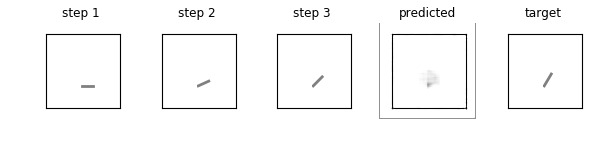

In [7]:
idx = 4

fig, axes = plt.subplots(figsize=((10, 3)), nrows=1, ncols=NUM_CHANNEL+2)

# display input images
for i, ax in enumerate(axes.flat[:NUM_CHANNEL]):
    ax.imshow(x_test[idx][:, :, i].reshape(HEIGHT, WIDTH), cmap='gray')
    ax.axis('off'), ax.set_title('step ' + str(i+1))
    
# display prediction
axes[NUM_CHANNEL].imshow(decoded_imgs[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
axes[NUM_CHANNEL].axis('off'), axes[NUM_CHANNEL].set_title('predicted')

# display target
axes[NUM_CHANNEL+1].imshow(y_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
axes[NUM_CHANNEL+1].axis('off'), axes[NUM_CHANNEL+1].set_title('target')

plt.show()